In [1]:
from models_code.utilities import create_model
from models_code.utilities import dump_results

from models_code.experiments import correlation_test_error_uncertainty
from models_code.experiments import correlation_test_error_uncertainty_variational
from models_code.experiments import load_notmnist
from models_code.experiments import load_omniglot
from models_code.experiments import load_cifar_bw
from models_code.experiments import random_generator

from models_code.experiments import not_mnist_predictions
from models_code.experiments import not_mnist_prediction_variational
from models_code.experiments import non_distribution
from models_code.experiments import test_eval
from models_code.experiments import test_eval_variational
from models_code.experiments import softmax
from models_code.experiments import softmax2d

from models_code.mnist import perform_training
from models_code.mnist import load_data

from models_code.mnist import Mnist
from models_code.mnist import ISMnist
from models_code.mnist import MCMnist
from models_code.mnist import MonteCarloDropout

from models_code.bayesbybackprop import BBPMnist
from models_code.bayesbybackprop import train_bbp, test_bbp

from models_code.utilities import load_model

from utilities.metric import predictive_entropy
from utilities.metric import entropy

import torch

import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

In [2]:
def set_same_seed():
    torch.manual_seed(9)
    torch.cuda.manual_seed(9)

In [3]:
batch_size = 128
log_interval = 100
epochs = 12

# Default model

In [ ]:
set_same_seed()
train_loader, test_loader = load_data(batch_size)

In [ ]:
# standard, optimizer, cross_entropy  = create_model(Mnist)

# perform_training(
#     epochs,
#     standard,
#     train_loader,
#     test_loader,
#     optimizer,
#     cross_entropy,
#     log_interval,
#     './models/mnist_lenet/standard2.torch',
#     60000 // batch_size + 1
# )

standard = load_model(Mnist, './models/mnist_lenet/standard.torch')

### First experiments - test accuracy

In [ ]:
test_preds, test_labels, test_probs = test_eval(standard, test_loader)

In [ ]:
accuracy_score(test_labels, test_preds)

In [ ]:
log_loss(test_labels, softmax(test_probs))

### Second experiment  - test error vs uncertainty


In [ ]:
roc, ac, fpr, tpr, pr, re = correlation_test_error_uncertainty(
    lambda x: entropy(x),
    softmax2d(test_probs),
    test_labels
)

print(roc)
print(ac)

roc, ac, fpr, tpr, pr, re = correlation_test_error_uncertainty(
    lambda x: -np.max(x, axis=1),
    softmax2d(test_probs),
    test_labels
)

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/mnist/standard.pickle')

### Third experiment - NOTMNIST vs MNIST

In [ ]:
not_mnist_loader = load_notmnist(batch_size)

In [ ]:
notmnist_truth, notmnist_probs, notmnist_images = not_mnist_predictions([standard], not_mnist_loader)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_probs,
    entropy(softmax2d(test_probs)).reshape(10000,1),
    entropy(notmnist_probs[0]).reshape(18724,1),
    28724,
    10000
)


# roc, ac, fpr, tpr, pr, re = non_distribution(
#     test_probs,
#     -np.max(softmax2d(test_probs), axis=1).reshape(10000,1),
#     -np.max(notmnist_probs[0], axis=1).reshape(18724,1),
#     28724,
#     10000
# )

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/notmnist/standard.pickle')

### Omniglot

In [ ]:
not_mnist_loader = load_omniglot(batch_size)

In [ ]:
notmnist_truth, notmnist_probs, notmnist_images = not_mnist_predictions([standard], not_mnist_loader)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_probs,
    entropy(softmax2d(test_probs)).reshape(10000,1),
    entropy(notmnist_probs[0]).reshape(32460,1),
    42460,
    10000
)



# roc, ac, fpr, tpr, pr, re = non_distribution(
#     test_probs,
#     -np.max(softmax2d(test_probs), axis=1).reshape(10000,1),
#     -np.max(notmnist_probs[0], axis=1).reshape(32460,1),
#     42460,
#     10000
# )

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/omniglot/standard.pickle')

### Cifar-bw

In [ ]:
not_mnist_loader = load_cifar_bw(batch_size)

In [ ]:
notmnist_truth, notmnist_probs, notmnist_images = not_mnist_predictions([standard], not_mnist_loader)

# roc, ac, fpr, tpr, pr, re = non_distribution(
#     test_probs,
#     entropy(softmax2d(test_probs)).reshape(10000,1),
#     entropy(notmnist_probs[0]).reshape(50000,1),
#     60000,
#     10000
# )



roc, ac, fpr, tpr, pr, re = non_distribution(
    test_probs,
    -np.max(softmax2d(test_probs), axis=1).reshape(10000,1),
    -np.max(notmnist_probs[0], axis=1).reshape(50000,1),
    60000,
    10000
)

In [ ]:
roc

In [ ]:
ac

# Monte Carlo Dropout

In [ ]:
set_same_seed()
train_loader, test_loader = load_data(batch_size)

In [ ]:
# mc, optimizer, cross_entropy  = create_model(MCMnist)

# perform_training(
#     # Has to be trained longer due to dropout
#     epochs * 2,
#     mc,
#     train_loader,
#     test_loader,
#     optimizer,
#     cross_entropy,
#     log_interval,
#     './models/mnist_lenet/mc.torch',
#     60000 // batch_size + 1
# )

mc = load_model(MCMnist, './models/mnist_lenet/mc.torch')

In [ ]:
mc.dropout = MonteCarloDropout(0.25)

In [ ]:
test_labels, test_preds = test_eval_variational(mc, test_loader, 50)

In [ ]:
accuracy_score(test_labels, np.argmax(np.mean(test_preds, axis=0), axis=1))

In [ ]:
log_loss(test_labels, np.mean(test_preds, axis=0))

### Second experiment

In [ ]:
roc, ac, fpr, tpr, pr, re = correlation_test_error_uncertainty_variational(
    predictive_entropy,
    test_preds,
    test_labels
)

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/mnist/mc.pickle')

### Third experiment


In [ ]:
not_mnist_loader = load_notmnist(batch_size)

In [ ]:
notmnist_labels, notmnist_probs, notmnist_images = not_mnist_prediction_variational(mc, not_mnist_loader, 50)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_preds,
    predictive_entropy(test_preds).reshape(10000,1),
    predictive_entropy(notmnist_probs).reshape(18724,1),
    28724,
    10000
)

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/notmnist/mc.pickle')

### Omniglot

In [ ]:
not_mnist_loader = load_omniglot(batch_size)

In [ ]:
notmnist_labels, notmnist_probs, notmnist_images = not_mnist_prediction_variational(mc, not_mnist_loader, 50)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_preds,
    predictive_entropy(test_preds).reshape(10000,1),
    predictive_entropy(notmnist_probs).reshape(32460,1),
    42460,
    10000
)

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/omniglot/mc.pickle')

### Cifar-bw

In [ ]:
not_mnist_loader = load_cifar_bw(batch_size)

In [ ]:
notmnist_labels, notmnist_probs, notmnist_images = not_mnist_prediction_variational(mc, not_mnist_loader, 50)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_preds,
    predictive_entropy(test_preds).reshape(10000,1),
    predictive_entropy(notmnist_probs).reshape(50000,1),
    60000,
    10000
)

In [ ]:
roc

In [ ]:
ac

# Bayes by Backprop

In [ ]:
set_same_seed()
train_loader, test_loader = load_data(batch_size)

In [ ]:
bbp, optimizer, cross_entropy  = create_model(BBPMnist)


# for epoch in range(1, 2 * epochs + 1):
#     train_bbp(bbp, optimizer, train_loader, cross_entropy, batch_size, log_interval, 60000 // batch_size + 1, epoch)
#     test_bbp(bbp, test_loader, cross_entropy, batch_size, epoch)


In [ ]:

# torch.save(bbp.state_dict(), './models/mnist_lenet/bbp.torch')

bbp = load_model(BBPMnist, './models/mnist_lenet/bbp.torch')

In [ ]:
test_labels, test_preds = test_eval_variational(bbp, test_loader, 10)

In [ ]:
accuracy_score(test_labels, np.argmax(np.mean(test_preds, axis=0), axis=1))

In [ ]:
log_loss(test_labels, np.mean(test_preds, axis=0))

### Second experiment

In [ ]:
roc, ac, fpr, tpr, pr, re = correlation_test_error_uncertainty_variational(
    predictive_entropy,
    test_preds,
    test_labels
)

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/mnist/bbp.pickle')

### Third experiment

In [ ]:
not_mnist_loader = load_notmnist(batch_size)

In [ ]:
notmnist_labels, notmnist_probs, notmnist_images = not_mnist_prediction_variational(bbp, not_mnist_loader, 10)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_preds,
    predictive_entropy(test_preds).reshape(10000,1),
    predictive_entropy(notmnist_probs).reshape(18724,1),
    28724,
    10000
)

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/notmnist/bp.pickle')

### Omniglot

In [ ]:
not_mnist_loader = load_omniglot(batch_size)

In [ ]:
notmnist_labels, notmnist_probs, notmnist_images = not_mnist_prediction_variational(bbp, not_mnist_loader, 10)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_preds,
    predictive_entropy(test_preds).reshape(10000,1),
    predictive_entropy(notmnist_probs).reshape(32460,1),
    42460,
    10000
)

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/omniglot/bp.pickle')

### Cifar-bw

In [ ]:
not_mnist_loader = load_cifar_bw(batch_size)

In [ ]:
notmnist_labels, notmnist_probs, notmnist_images = not_mnist_prediction_variational(mc, not_mnist_loader, 10)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_preds,
    predictive_entropy(test_preds).reshape(10000,1),
    predictive_entropy(notmnist_probs).reshape(50000,1),
    60000,
    10000
)

In [ ]:
roc

In [ ]:
ac

# Inhibited softmax

In [4]:
set_same_seed()
train_loader, test_loader = load_data(batch_size)

In [5]:
# is_, optimizer, cross_entropy  = create_model(ISMnist)


# def is_loss(model):
    
#     return (
#         lambda pred,y: cross_entropy(pred,y)
#         + 0.01 * (model.dense3.weight.data ** 2).sum()
#         + 0.000001 * pred.sum()
#     )

# perform_training(
#     epochs,
#     is_,
#     train_loader,
#     test_loader,
#     optimizer,
#     is_loss(is_),
#     log_interval,
#     './models/mnist_lenet/is.torch',
#     60000 // batch_size + 1
# )

is_ = load_model(ISMnist, './models/mnist_lenet/is.torch')

In [6]:
test_preds, test_labels, test_probs = test_eval(is_, test_loader)

In [7]:
accuracy_score(test_labels, test_preds)

0.9918

In [10]:
log_loss(test_labels, softmax2d(test_probs[:,:10]))

0.028906015356990774

### Second experiment

In [ ]:
roc, ac, fpr, tpr, pr, re = correlation_test_error_uncertainty(
    lambda x: softmax2d(x)[:,10],
    test_probs,
    test_labels
)


In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/mnist/is.pickle')

### Third experiment

In [8]:
not_mnist_loader = load_notmnist(batch_size)

In [ ]:
notmnist_truth, notmnist_probs, notmnist_images = not_mnist_predictions([is_], not_mnist_loader, softmaxed=False)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_probs,
    softmax2d(test_probs)[:,10].reshape(10000,1),
    softmax2d(notmnist_probs[0])[:,10].reshape(18724,1),
    28724,
    10000
)


In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/notmnist/is.pickle')

### Omniglot

In [7]:
not_mnist_loader = load_omniglot(batch_size)

In [ ]:
notmnist_truth, notmnist_probs, notmnist_images = not_mnist_predictions([is_], not_mnist_loader, softmaxed=False)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_probs,
    softmax2d(test_probs)[:,10].reshape(10000,1),
    softmax2d(notmnist_probs[0])[:,10].reshape(32460,1),
    42460,
    10000
)

# roc, ac, fpr, tpr, pr, re = non_distribution(
#     test_probs,
#     entropy(softmax2d(test_probs[:,:10])).reshape(10000,1),
#     entropy(softmax2d(notmnist_probs[0,:,:10])).reshape(32460,1),
#     42460,
#     10000
# )

In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/omniglot/is.pickle')

### Cifar-bw

In [ ]:
not_mnist_loader = load_cifar_bw(batch_size)

In [ ]:
notmnist_truth, notmnist_probs, notmnist_images = not_mnist_predictions([is_], not_mnist_loader, softmaxed=False)

In [ ]:
roc, ac, fpr, tpr, pr, re = non_distribution(
    test_probs,
    softmax2d(test_probs)[:,10].reshape(10000,1),
    softmax2d(notmnist_probs[0])[:,10].reshape(50000,1),
    60000,
    10000
)



In [ ]:
roc

In [ ]:
ac

In [ ]:
dump_results(fpr, tpr, pr, re, './results/cifar-bw/is.pickle')

### Plot

In [9]:
from torch.autograd import Variable

all_ys = []
not_mnist_ys = []

for i, (data, y) in enumerate(test_loader):
    data = data.cuda()
    data = Variable(data, volatile=True)
    y_ = is_.after_activation(data.view(-1, 1, 32, 32))
    all_ys.append(y_.cpu().data.numpy())
    
for i, (data, y) in enumerate(not_mnist_loader):
    data = data.cuda()
    data = Variable(data, volatile=True)
    y_ = is_.after_activation(data.view(-1, 1, 32, 32))
    not_mnist_ys.append(y_.cpu().data.numpy())

In [10]:
from matplotlib import pyplot as plt

(array([1901., 1535.,  999.,  803.,  738.,  701.,  711.,  724.,  903.,
        1737.]),
 array([0.00491058, 0.10441951, 0.20392844, 0.30343737, 0.4029463 ,
        0.50245523, 0.60196416, 0.70147309, 0.80098202, 0.90049095,
        0.99999988]),
 <a list of 10 Patch objects>)

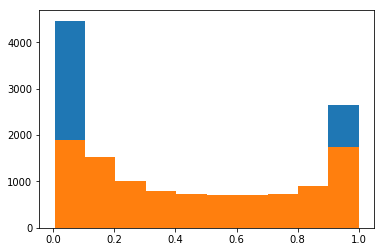

In [11]:
plt.hist(all_ys[0].flatten())
plt.hist(not_mnist_ys[0].flatten())

In [12]:
stacked_all_ys = np.concatenate(all_ys)
stacked_all_ys_nm = np.concatenate(not_mnist_ys)

/home/msusik/.virtualenvs/sigmoidal/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


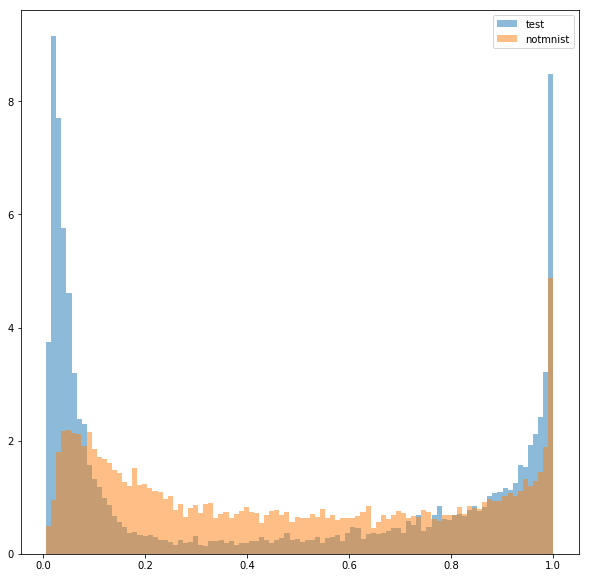

In [13]:
plt.figure(figsize=(10,10))
plt.hist(all_ys[0].flatten(),bins=100, alpha=0.5,normed=True,label='test')
_ = plt.hist(not_mnist_ys[0].flatten(),bins=100, alpha=0.5,normed=True,label='notmnist')
plt.legend()